In [ ]:
#Ongoing list of imports/packages
import scipy as sp
from pylab import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
import networkx as nx
import seaborn as sns
import collections
from IPython.display import clear_output
import random
from scipy.stats import mannwhitneyu
import pandas as pd
from google.colab import drive
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet
from scipy.spatial.distance import pdist
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.tree import plot_tree
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score



drive.mount('/content/drive')

Mounted at /content/drive


## Data cleaning and reorganization from GEO accession
### Work flow and pseudocode is below

Following the GEO accession there are two files. One file we are assuming comes from the manufacturer of the RNA microarray or as a read out has an index, NM ID, common gene abbreviation, full name of gene, GO accession and probe sequences. The second file has indexes and result values by patient. This also includes metadata on the patients.

After uploading the .txt files. Metadata was removed and the files were merged so the final dataset has the corresponding NM IDs, index value, gene abb, and patient samples expression values.

The next file contains all of the phenotypic data from the samples (there can be multiple samples from a patient)


In [ ]:
#uploading GEO accesion data
file_path = '/content/drive/MyDrive/20440_Project/GSE11223_series_matrix.txt'
#converting txt to data frame (removing metadata)
raw_file = pd.read_csv(file_path, delimiter='\t', skiprows=139)

#uploading Microarray GeneID data probes and
file_path = '/content/drive/MyDrive/20440_Project/GeneID_Probes.txt'
#converting txt to data frame
ID_raw = pd.read_csv(file_path, delimiter='\t', header = None)


<ipython-input-5-533aad3bec52>:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_file = pd.read_csv(file_path, delimiter='\t', skiprows=139)


In [ ]:
#extracting ID_ref, NM_... ID, and Gene Names
ID_abb = ID_raw.iloc[:,[0,3,9]]
Column_names = ['ID_REF', 'NM_ID', 'GeneID']
ID_abb.columns = Column_names
#making sure everything is same dtype before merge
ID_abb.loc[:, 'ID_REF']=ID_abb.loc[:, "ID_REF"].astype(str)
ID_abb.loc[:, 'NM_ID']=ID_abb.loc[:, "NM_ID"].astype(str)
ID_abb.loc[:, 'GeneID']=ID_abb.loc[:, "GeneID"].astype(str)
#Replacing GeneID with NM_ID if blank
for index, row in ID_abb.iterrows():
  if row['GeneID']== 'nan':
    ID_abb.at[index, 'GeneID'] = row['NM_ID']

#Renaming ID_REF column on raw data
column = list(raw_file.columns)
raw_file.rename(columns= {column[0]: 'ID_REF'}, inplace = True)
#making sure everything is same dtype before merge
raw_file.loc[:, 'ID_REF'] = raw_file.loc[:, 'ID_REF'].astype(str)
#replacing NaN values with 0
raw_file = raw_file.fillna(0)

#adding NM_... ID and Gene Names to patient values
merged_df = pd.merge(raw_file, ID_abb, on='ID_REF', how ='left')

#extracting the name of the columns
column_names = list(merged_df.columns)

#adding NM_ID, GeneID to front of df
new_order = column_names[-2:] + column_names[:-2]
merged_df_reorg = merged_df[new_order]


<ipython-input-6-3dfbf9bcd387>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID_abb.loc[:, 'ID_REF']=ID_abb.loc[:, "ID_REF"].astype(str)
<ipython-input-6-3dfbf9bcd387>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID_abb.loc[:, 'NM_ID']=ID_abb.loc[:, "NM_ID"].astype(str)
<ipython-input-6-3dfbf9bcd387>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [ ]:
#uploading sample metadata
file_path = '/content/drive/MyDrive/20440_Project/GSE11223_newPheno.txt'
#converting txt to data frame
sample_info = pd.read_csv(file_path, delimiter='\t')
print(sample_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   GSM                        202 non-null    object 
 1   Patient                    202 non-null    int64  
 2   Current.Medication         202 non-null    object 
 3   Birth.Date                 202 non-null    object 
 4   Gender                     202 non-null    object 
 5   Ethnicity                  202 non-null    object 
 6   Symptoms.Onset.Date        127 non-null    object 
 7   Diagnosis.Date             126 non-null    object 
 8   Joint.Problems             202 non-null    bool   
 9   Uc.Flare.Up                202 non-null    bool   
 10  Family.History             202 non-null    bool   
 11  Aza.Treated                129 non-null    object 
 12  Aza.Tolerant               202 non-null    bool   
 13  Aza.At.Present             202 non-null    bool   

## Data manipulation
### Here we are going to ensure that the data is normalized. We are going to perform heirarchical clustering using a variety of parameters and evaluators.  

                  0          1          2             3          4      \
NM_ID      NM_001003689  NM_005503  NM_004672  NM_001008727  NM_020630   
GeneID          L3MBTL2      APBA2     MAP3K6        ZNF121        RET   
ID_REF                3          4          5             6          8   
GSM282855      0.038661   -0.13288  -0.042229      -0.21233        0.0   
GSM282856      -0.10887   -0.10885   0.042197      -0.23983   -0.11532   

              5                6          7         8          9      ...  \
NM_ID      BX094364  ENST00000333722  NM_003927  BC038371  NM_153610  ...   
GeneID     BX094364  ENST00000333722       MBD2  BC038371      CMYA5  ...   
ID_REF            9               10         12        13         15  ...   
GSM282855  0.034649         0.028586    0.15138  -0.26825        0.0  ...   
GSM282856  0.014877        -0.042214    0.21129  -0.47905  -0.032859  ...   

               40982       40983      40984      40985      40986       40987  \
NM_ID      

Text(0.5, 1.0, 'Expression Value Distribution of 3 Sample Genes')

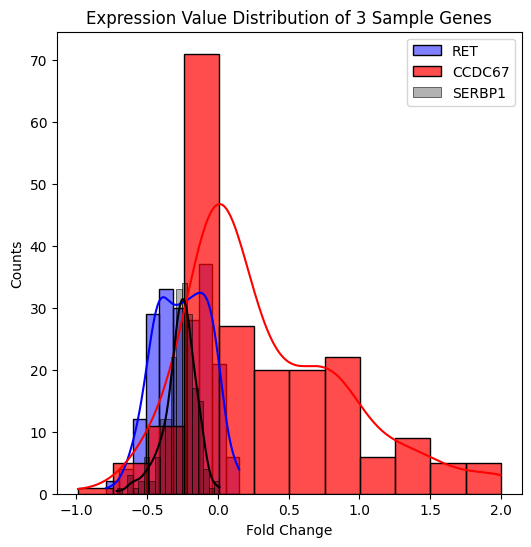

In [ ]:
#Transposing data so each sample is a row and each gene expression value is a column
merged_df_trans = merged_df_reorg.transpose()
print(merged_df_trans.head())

#determining if the data is normalized
fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(merged_df_trans.iloc[3:, 4], kde = True, color = 'blue', alpha = 0.5, label = merged_df_trans.iloc[1,4])
sns.histplot(merged_df_trans.iloc[3:, 10], kde = True, color = 'red', alpha = 0.7, label = merged_df_trans.iloc[1,10])
sns.histplot(merged_df_trans.iloc[3:, 100], kde = True, color = 'black', alpha = 0.3, label = merged_df_trans.iloc[1,100])
plt.legend()
plt.xlabel("Fold Change")
plt.ylabel("Counts")
plt.title("Expression Value Distribution of 3 Sample Genes")

<ipython-input-33-55ce1dccf1b1>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


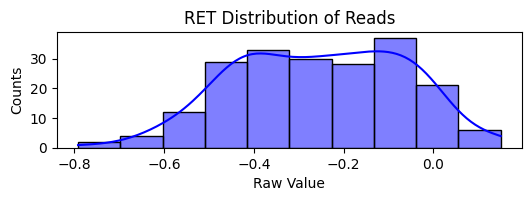

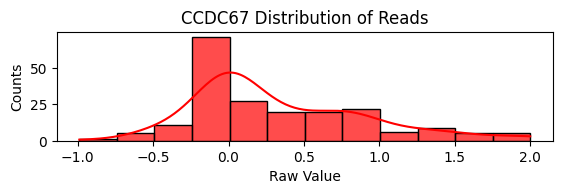

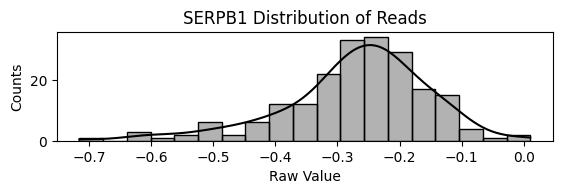

In [ ]:
#determining if the data is normalized alternate figures
fig, ax = plt.subplots(figsize = (6,6))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

plt.subplot(3,1,1)
sns.histplot(merged_df_trans.iloc[3:, 4], kde = True, color = 'blue', alpha = 0.5, label = merged_df_trans.iloc[1,4])
plt.title("RET Distribution of Reads")
plt.xlabel("Raw Value")
plt.ylabel("Counts")
plt.show()

plt.subplot(3,1,2)
sns.histplot(merged_df_trans.iloc[3:, 10], kde = True, color = 'red', alpha = 0.7, label = merged_df_trans.iloc[1,10])
plt.title("CCDC67 Distribution of Reads")
plt.xlabel("Raw Value")
plt.ylabel("Counts")
plt.show()

plt.subplot(3,1,3)
sns.histplot(merged_df_trans.iloc[3:, 100], kde = True, color = 'black', alpha = 0.3, label = merged_df_trans.iloc[1,100])
plt.title("SERPB1 Distribution of Reads")
plt.xlabel("Raw Value")
plt.ylabel("Counts")
plt.show()

Text(0.5, 1.0, 'NORMALIZED Expression Value Distribution of 3 Sample Genes')

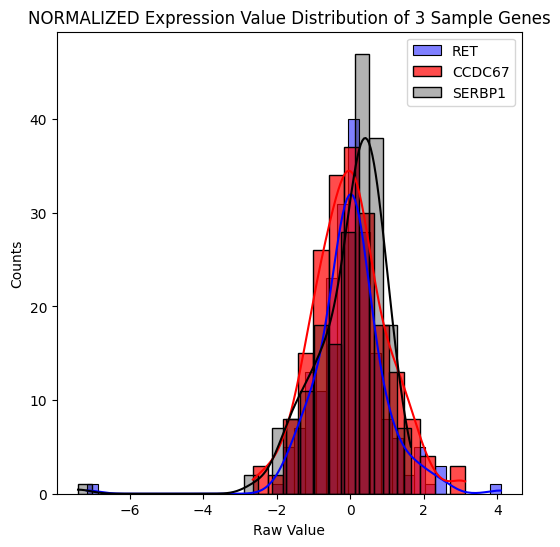

In [ ]:
#Standardizing Data
scaler = StandardScaler()
numerical_feature = merged_df_trans.columns[1:]
reads = merged_df_trans.iloc[3: -1][numerical_feature]
Merged = scaler.fit_transform(reads)

#Determining if the data is normalized
fig, ax = plt.subplots(figsize = (6,6))
sns.histplot(Merged[:,4], kde = True, color = 'blue', alpha = 0.5, label = merged_df_trans.iloc[1,4])
sns.histplot(Merged[:,10], kde = True, color = 'red', alpha = 0.7, label = merged_df_trans.iloc[1,10])
sns.histplot(Merged[:,100], kde = True, color = 'black', alpha = 0.3, label = merged_df_trans.iloc[1,100])
plt.legend()
plt.xlabel("Raw Value")
plt.ylabel("Counts")
plt.title("NORMALIZED Expression Value Distribution of 3 Sample Genes")

Text(0.5, 1.0, 'Dendrogram')

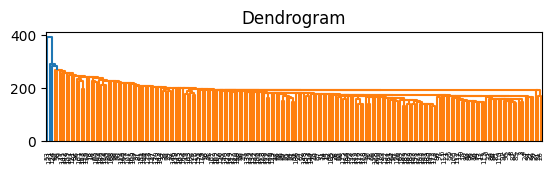

In [ ]:
distances = pdist(Merged, metric = 'euclidean')
linkage = fastcluster.linkage(distances, method = 'single')
plt.subplot(3,1,1)
dendrogram(linkage)
plt.title("Dendrogram")


In [ ]:
# Create a heatmap subplot
# Will take about 5 mins to run
heatmap = sns.clustermap(merged_df_trans.iloc[3:, 1:-1].apply(pd.to_numeric, errors='coerce'), cmap='viridis', standard_scale=1)
plt.title('Heatmap and Clustering of Normalized Expression Data and Sample IDs')
heatmap.ax_heatmap.set_xlabel("GENE Expression Number")
heatmap.ax_heatmap.set_ylabel("Sample ID Number")
plt.show()

KeyboardInterrupt: 

In [ ]:

merged_df_trans.iloc[[1, 2]] = merged_df_trans.iloc[[2, 1]].to_numpy()
Reads = merged_df_trans.iloc[2:, :-2]
print(Reads.head())

heatmap = sns.clustermap(Reads.apply(pd.to_numeric, errors='coerce'), cmap='viridis')
plt.title('Heatmap and Clustering of Fold Change and Sample IDs')
heatmap.ax_heatmap.set_xlabel("GENE Expression Number")
heatmap.ax_heatmap.set_ylabel("Sample ID Number")
plt.show()

              0        1         2        3        4         5      \
ID_REF      L3MBTL2    APBA2    MAP3K6   ZNF121      RET  BX094364   
GSM282855  0.038661 -0.13288 -0.042229 -0.21233      0.0  0.034649   
GSM282856  -0.10887 -0.10885  0.042197 -0.23983 -0.11532  0.014877   
GSM282857  -0.04431 -0.13558  0.017986 -0.33934 -0.44221 -0.054095   
GSM282858 -0.033416 -0.11883  0.063459 -0.31396 -0.24953 -0.058241   

                     6        7         8         9      ...     40980  \
ID_REF     ENST00000333722     MBD2  BC038371     CMYA5  ...      EMR1   
GSM282855         0.028586  0.15138  -0.26825       0.0  ... -0.087213   
GSM282856        -0.042214  0.21129  -0.47905 -0.032859  ... -0.069767   
GSM282857         0.031149  0.19592  -0.32326  -0.27542  ... -0.074031   
GSM282858        -0.057668  0.21552  -0.34305  0.059959  ...  -0.10345   

                  40981      40982       40983      40984     40985     40986  \
ID_REF     A_32_P206917  LOC285749  THC2406077  TNFRS

KeyboardInterrupt: 

In [ ]:
print(sample_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 53 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   GSM                        202 non-null    object 
 1   Patient                    202 non-null    int64  
 2   Current.Medication         202 non-null    object 
 3   Birth.Date                 202 non-null    object 
 4   Gender                     202 non-null    object 
 5   Ethnicity                  202 non-null    object 
 6   Symptoms.Onset.Date        127 non-null    object 
 7   Diagnosis.Date             126 non-null    object 
 8   Joint.Problems             202 non-null    bool   
 9   Uc.Flare.Up                202 non-null    bool   
 10  Family.History             202 non-null    bool   
 11  Aza.Treated                129 non-null    object 
 12  Aza.Tolerant               202 non-null    bool   
 13  Aza.At.Present             202 non-null    bool   

In [ ]:
Diagnosis = sample_info.iloc[:, [1, 35, 36, 37, 38, 39]]
print(Diagnosis.iloc[190:, :])
Number_pt = sample_info["Patient"].nunique()

print(Number_pt)

     Patient Diagnosis.Rectum Diagnosis.Recto.Sigmoid Diagnosis.Splen.Flex  \
190      265             BOTH                    BOTH                 BOTH   
191      265             BOTH                    BOTH                 BOTH   
192      267             BOTH                    BOTH              unknown   
193      267             BOTH                    BOTH              unknown   
194      249             BOTH                    BOTH                 BOTH   
195      249             BOTH                    BOTH                 BOTH   
196      260             BOTH                 unknown              unknown   
197      260             BOTH                 unknown              unknown   
198      260             BOTH                 unknown              unknown   
199      262             BOTH                    BOTH              unknown   
200      262             BOTH                    BOTH              unknown   
201      266             BOTH                    BOTH           